In [1]:
# %%
from SonicBatt import utils
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
import pickle

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'multi-cell_ml')
data_path = os.path.join(study_path, 'Raw Data')
ancillary_data_path = os.path.join(study_path, 'Ancillary Data')
visualistion_path = os.path.join(study_path, 'Visualisation')
unsupervised_models_path = os.path.join(study_path, 'Models', 'Unsupervised')
autoencoders_path = os.path.join(unsupervised_models_path, 'Autoencoders')

# --------------------------
# Loading the spectrogram just to get the y labels.
parquet_filename = 'signals_peaks_fft.parquet'
parquet_filepath = os.path.join(ancillary_data_path, parquet_filename)
df = pd.read_parquet(parquet_filepath)

# Shuffle and continue
indices_all = df.index.to_numpy().copy() # !!! The following alternative didn't work --> #df.copy(deep=True).index.to_numpy()
np.random.seed(42)
np.random.shuffle(indices_all)
df = df.loc[indices_all].reset_index(drop=True)

# Replace cell_ids with the cell aliases
database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
df_cell_aliases =  pd.read_excel(os.path.join(data_path, 'database.xlsx'),
                              sheet_name='cell_aliases')
cell_aliases = {}
for _, row in df_cell_aliases.iterrows():
    cell_aliases[row['cell_id']] = row['cell_alias']
label_column = ('cycling', 'Cell_ID')
df[label_column] = df[label_column].replace(cell_aliases)
y = df.loc[:, label_column].to_numpy()
del (df)
# --------------------------

import json
with open(os.path.join(ancillary_data_path,'cells_together_split.json'), 'r') as fp:
    cells_together_split = json.load(fp)
test_indices = cells_together_split['test']
y_test = y[test_indices]

colors = plt.cm.tab10.colors  # Get colors from tab10
cmap = mcolors.ListedColormap(colors[:7][::-1]) # Reverse them to look prettier


In [2]:
# %%
data_configs = {
    'B': ['peak_tofs'],
    'C': ['peak_tofs', 'peak_heights'],
    'D': ['acoustics'],
    'E': ['fft_magns'],
    'F': ['acoustics', 'fft_magns'],
    'G': 'spectrograms'
}


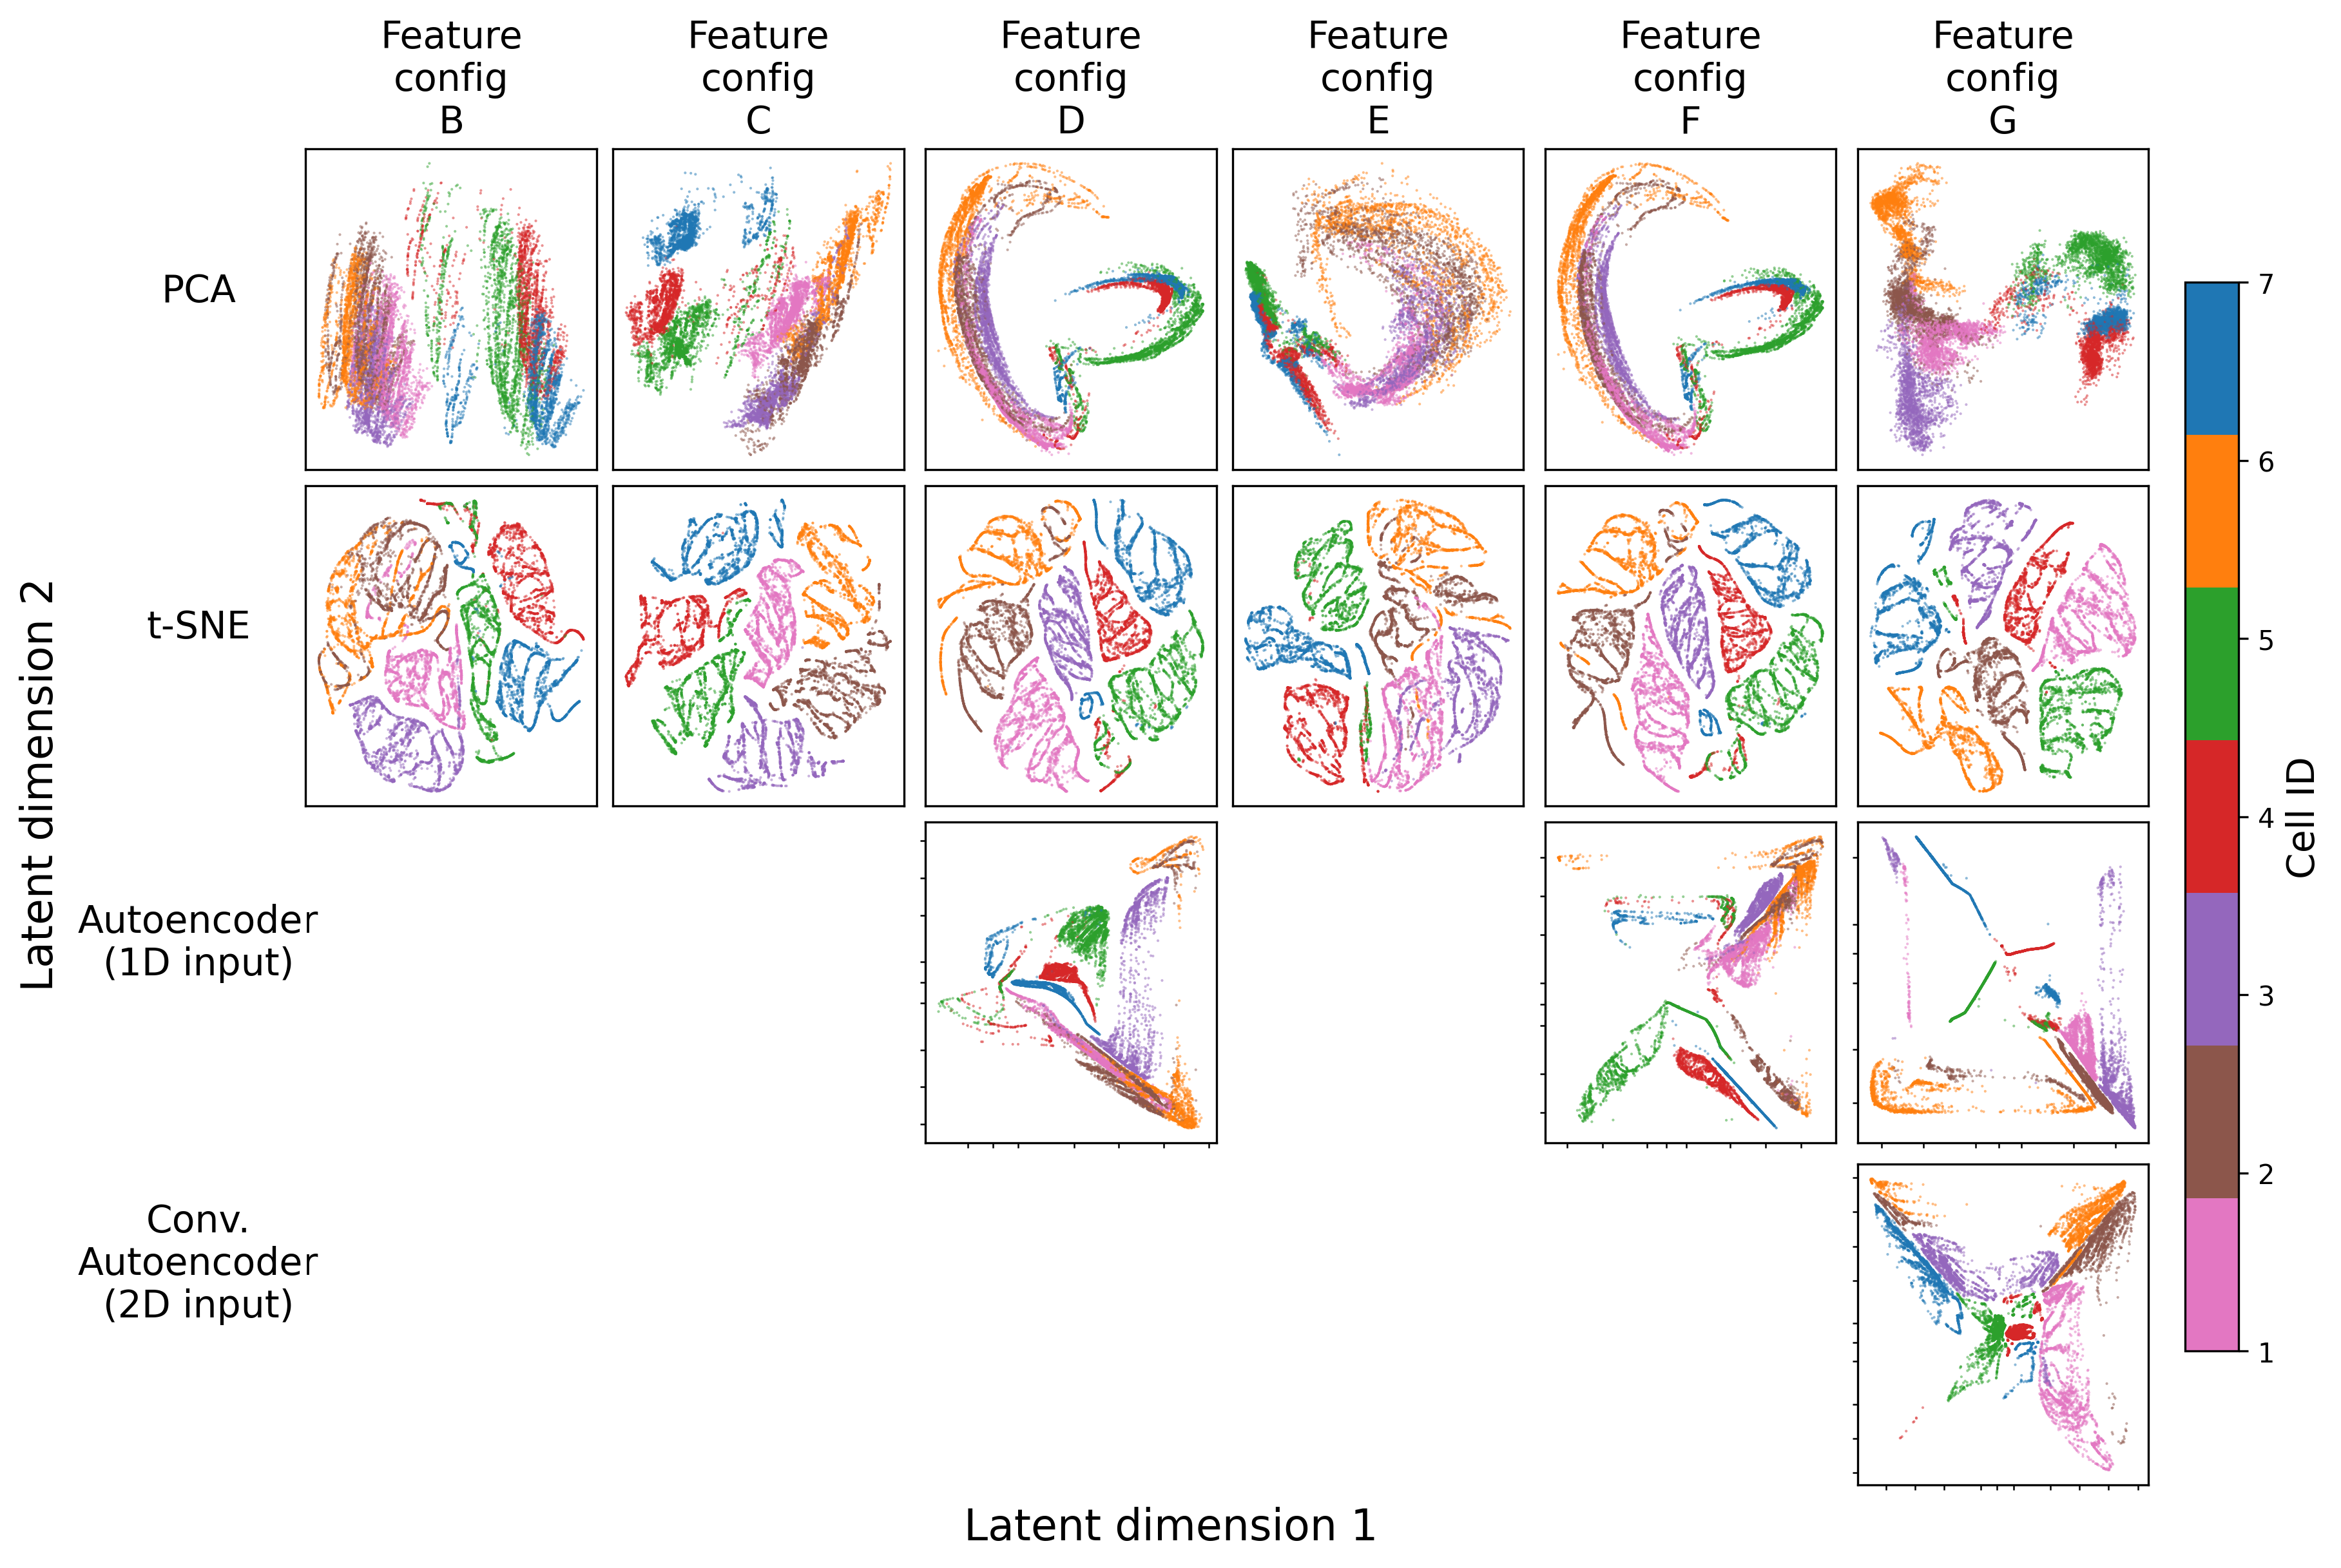

In [3]:
# %%
# PCA TSNE and Autoencoder visualisation
mpl.rc('axes', labelsize=14, titlesize=14)

s=1
f, axs = plt.subplots(4,6, figsize=(12,8), constrained_layout=True, dpi=300)
for i, data_config in enumerate(data_configs.keys()):
    # PCA
    model_name = 'PCA_{}'.format(data_config)
    model_dir = os.path.join(unsupervised_models_path, model_name) + '.pkl'
    with open(model_dir, 'rb') as fa:
        projected = pickle.load(fa)
    axs[0,i].scatter(projected[:, 0], projected[:, 1],
        c=y_test, edgecolor='none', alpha=0.5, cmap=cmap,s=s)
    # # TSNE
    model_name = 'TSNE_{}'.format(data_config)
    model_dir = os.path.join(unsupervised_models_path, model_name) + '.pkl'
    with open(model_dir, 'rb') as fa:
        projected = pickle.load(fa)
    axs[1,i].scatter(projected[:, 0], projected[:, 1],
        c=y_test, edgecolor='none', alpha=0.5, cmap=cmap,s=s)
    
    # Autoencoders with flattened input
    model_name = 'autoencoder_sch2_{}_scaled'.format(data_config)
    projection_dir = os.path.join(autoencoders_path, '{}_projected.npy'.format(model_name))
    if os.path.exists(projection_dir):
        projected = np.load(projection_dir)
        axs[2,i].scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5, cmap=cmap,s=s)
        axs[2,i].set_xscale('symlog')
        axs[2,i].set_yscale('symlog')
    else:
        if i != 0:
            axs[2,i].axis('off')
        else:
            axs[2,i].spines['top'].set_visible(False)
            axs[2,i].spines['bottom'].set_visible(False)
            axs[2,i].spines['right'].set_visible(False)
            axs[2,i].spines['left'].set_color('white')
    
    # Convolutional autoencoder
    model_name = 'conv_autoencoder_sch2_{}_scaled'.format(data_config)
    projection_dir = os.path.join(autoencoders_path, '{}_projected.npy'.format(model_name))
    if os.path.exists(projection_dir):
        projected = np.load(projection_dir)
        axs[3,i].scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5, cmap=cmap,s=s)
        axs[3,i].set_xscale('symlog')
        axs[3,i].set_yscale('symlog')
    else:
        if i != 0:
            axs[3,i].axis('off')
        else:
            axs[3,i].spines['top'].set_visible(False)
            axs[3,i].spines['bottom'].set_visible(False)
            axs[3,i].spines['right'].set_visible(False)
            axs[3,i].spines['left'].set_color('white')        

    # Axis house keeping
    axs[0,i].set_title('Feature\nconfig\n{}'.format(data_config))
    for j in range(4):
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])

pad = 40
axs[0,0].set_ylabel('PCA', rotation=0, labelpad=pad)
axs[1,0].set_ylabel('t-SNE', rotation=0, labelpad=pad)
axs[2,0].set_ylabel('Autoencoder\n(1D input)', rotation=0, labelpad=pad)
axs[3,0].set_ylabel('Conv.\nAutoencoder\n(2D input)', rotation=0, labelpad=pad)
f.supxlabel('Latent dimension 1', fontsize=16)
f.supylabel('Latent dimension 2', fontsize=16)
f.align_ylabels()

sm = ScalarMappable(cmap=cmap)
sm.set_array(y)
cbar = f.colorbar(sm, ax=axs, label='Cell ID', shrink=0.8, pad=0.02)
cbar.set_ticks(np.unique(y))

# save_filename = 'Unsupervised'
# utils.save_figure(f, visualistion_path, save_filename, format='png')

mpl.rcdefaults()


Text(0.02, 0.5, 'MAE')

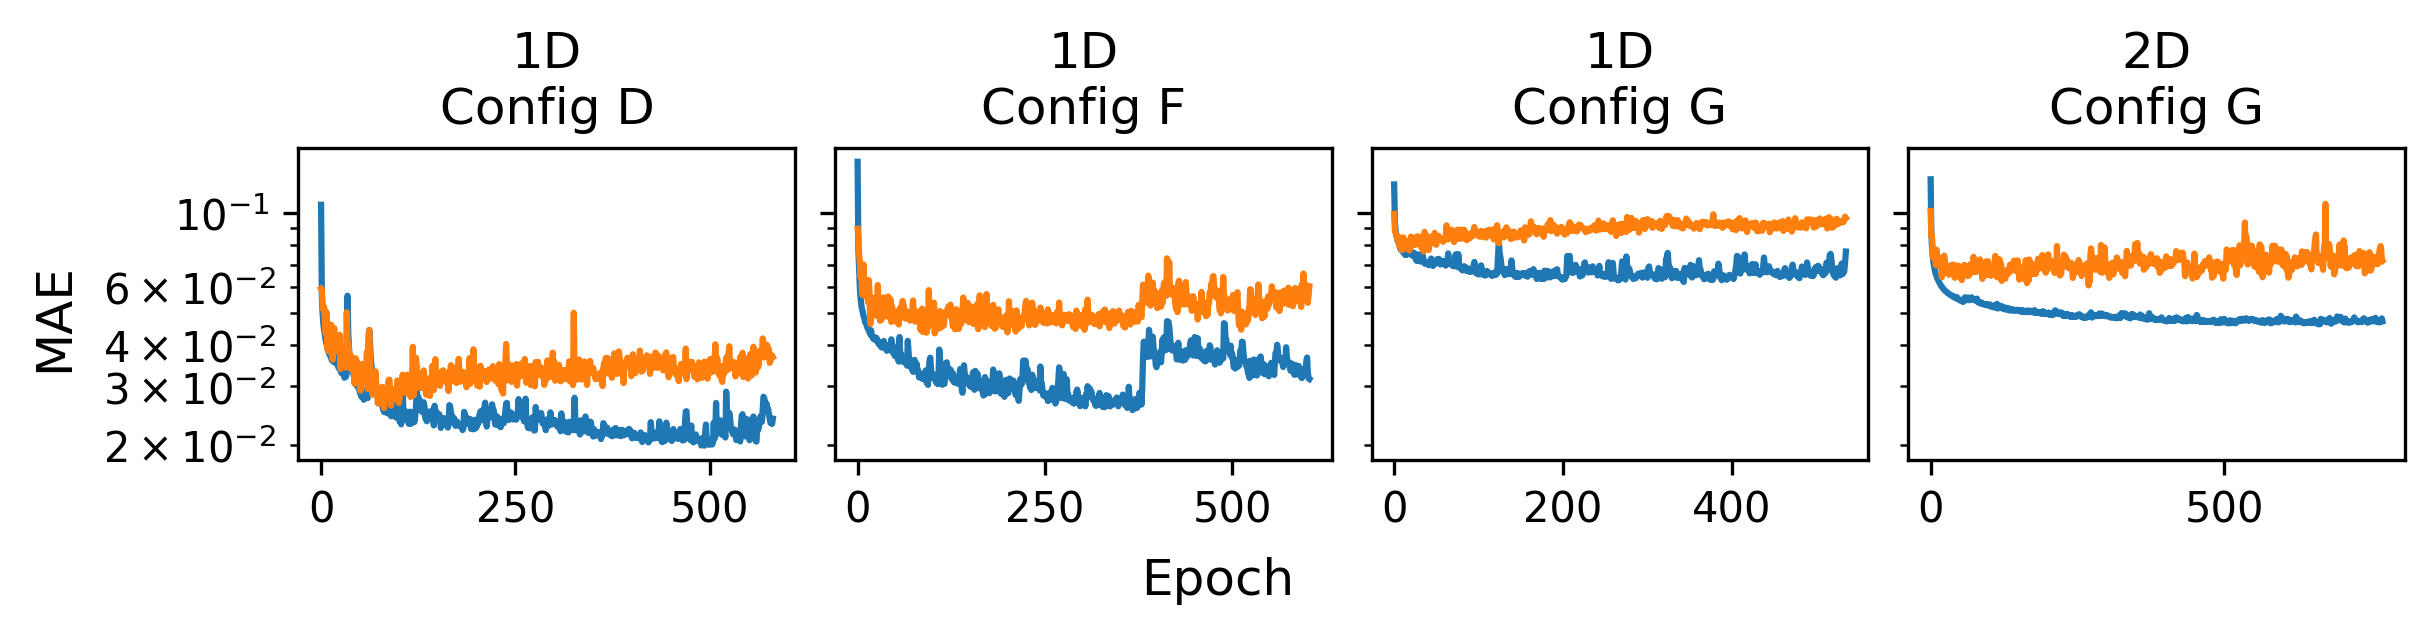

In [4]:
# %%
# Check learning curves of autoencoders:
import json
data_configs = ['D', 'F', 'G', 'G']
titles = ['1D\nConfig D', '1D\nConfig F', '1D\nConfig G', '2D\nConfig G']
model_names = [
    'autoencoder_sch2_D_scaled',
    'autoencoder_sch2_F_scaled',
    'autoencoder_sch2_G_scaled',
    'conv_autoencoder_sch2_G_scaled',
]
f, axs = plt.subplots(1,4, figsize=(8,2), constrained_layout=True,
                      dpi=300, sharey=True)
for i, data_config in enumerate(data_configs):
    model_name = model_names[i]
    model_dir = os.path.join(autoencoders_path, model_name)
    with open(os.path.join(model_dir,'training_history.json'), 'r') as fp:
        history = json.load(fp)
    n_epochs = len(history['loss'])
    axs[i].plot(np.arange(n_epochs), history['loss'], label='training')
    axs[i].plot(np.arange(n_epochs), history['val_loss'], label='validation')
    axs[i].set_yscale('log')
    axs[i].set_title(titles[i])
f.supxlabel('Epoch')
f.supylabel('MAE')


In [ ]:
# %%